In [45]:
import clickhouse_connect
from dotenv import load_dotenv
from google.cloud import bigquery
import json
import matplotlib.pyplot as plt
import pandas as pd
import os

from scripts.charts import distributions_barchart


load_dotenv()
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
CLICKHOUSE_HOST = os.environ['CLICKHOUSE_HOST']
CLICKHOUSE_USER = os.environ['CLICKHOUSE_USER']
CLICKHOUSE_PASS = os.environ['CLICKHOUSE_PASSWORD']

GCP_PROJECT = 'opensource-observer'

In [2]:
df_funding = pd.read_csv('../../../../oss-funding/data/funding_data.csv')

df_funding = df_funding[df_funding['from_funder_name'] == 'optimism']
df_funding = df_funding[df_funding['grant_pool_name'].str.contains('retro')==True]

df_funding['metadata'] = df_funding['metadata'].apply(json.loads)
df_funding['application_name'] = df_funding['metadata'].apply(lambda x: x.get('application_name'))
df_funding['round'] = df_funding['grant_pool_name'].apply(lambda x: int(x[-1]))

df_funding['tokens'] = df_funding['metadata'].apply(lambda x: pd.to_numeric(x['token_amount']))
df_funding = df_funding[df_funding['tokens'] > 0]

df_funding.rename(columns={'to_project_name': 'project_name'}, inplace=True)
cols = ['application_name', 'project_name', 'round', 'tokens', 'amount']
df_funding = df_funding[cols]

df_funding.tail(1)

,application_name,project_name,round,tokens,amount
1443,Solady,solady-vectorized,5,95072.810791,161623.778345


In [3]:
df_funding.groupby('round')['amount'].sum() / 1_000_000

round
2     15.000011
3    104.999999
4     18.000000
5     13.600000
Name: amount, dtype: float64

In [4]:
cols = [
    'name', 'organization', 'round', 'category', 'profileAvatarUrl',
    'github', 'contracts', 'grantsAndFunding'
]
def load_project_json(round_num):
    with open(f'data/_local/rf{round_num}_projects.json', 'r') as f:        
        rf_data = json.load(f)
        df_rf = pd.DataFrame(rf_data).set_index('applicationId')
        df_rf['round'] = round_num
        if round_num == 4:
            df_rf['category'] = df_rf['category'].str.upper()
            df_rf['organization'] = df_rf['name']
        else:
            df_rf['category'] = df_rf['applicationCategory']
            df_rf['organization'] = df_rf.apply(
                lambda x: x['organization'].get('name') if isinstance(x['organization'], dict) else x['name'],
                axis=1
            )
        return df_rf[cols]
    
def extract_funding(x, funding_type):
    if isinstance(x, dict):
        f = x.get(funding_type, [])
        if len(f) > 0:
            return True
        else:
            if funding_type == 'retroFunding':
                grants = x.get('grants', [])
                if len(grants):
                    for g in grants:
                        if g['grant'] == 'retroFunding':
                            return True
    return False

def get_grant_amounts(x):
    funding = 0
    if isinstance(x, dict):
        grants = x.get('grants', [])
        if len(grants):
            for g in grants:
                if g['grant'] == 'retroFunding':
                    continue
                try:
                    funding += pd.to_numeric(g['amount'])
                except:
                    continue
    return funding

def get_githubs(x):
    githubs = []
    if not isinstance(x, list):
        return githubs
    for item in x:
        if isinstance(item, str):
            githubs.append(item.lower())
        else:
            g = item.get('url')
            githubs.append(g.lower())
    return githubs    

In [5]:
rounds = [4,5,6]
df = pd.concat([load_project_json(r) for r in rounds], axis=0, ignore_index=True)    

df['partOfOrganization'] = (df['organization'] == df['name'])   
df['hasVentureFunding'] = df['grantsAndFunding'].apply(lambda x: extract_funding(x, 'ventureFunding'))
df['hasRevenue'] = df['grantsAndFunding'].apply(lambda x: extract_funding(x, 'revenue'))
df['hasRetroFunding'] = df['grantsAndFunding'].apply(lambda x: extract_funding(x, 'retroFunding'))
df['grantAmounts'] = df['grantsAndFunding'].apply(get_grant_amounts)
df['hasGrants'] = df['grantAmounts'] > 0
df['github'] = df['github'].apply(get_githubs)

df.tail(1)

,name,organization,round,category,profileAvatarUrl,github,contracts,grantsAndFunding,partOfOrganization,hasVentureFunding,hasRevenue,hasRetroFunding,grantAmounts,hasGrants
390,Optimism Grant analytics: Grant3,OP Grants Tracker,6,GOVERNANCE_ANALYTICS,https://storage.googleapis.com/op-atlas/2094ae...,[],[],"{'ventureFunding': [], 'grants': [], 'revenue'...",False,False,False,True,0.0,False


In [6]:
# https://docs.google.com/spreadsheets/d/1Ul8iMTsOFUKUmqz6MK0zpgt8Ki8tFtoWKGlwXj-Op34/edit?gid=769451685#gid=769451685
print("Total prospective grants:")
(
    df.drop_duplicates(subset=['organization', 'grantAmounts'])
    .sort_values(by='grantAmounts')
    ['grantAmounts'].sum()
)

Total prospective grants:


34468206.31

In [7]:
print("Projects with revenue:")
(
    df.drop_duplicates(subset=['organization', 'hasRevenue'])
    .groupby('hasVentureFunding')
    ['hasRevenue'].value_counts()
)

Projects with revenue:


hasVentureFunding  hasRevenue
False              False         171
                   True          116
True               True           44
                   False          20
Name: count, dtype: int64

In [8]:
print("Venture capital analysis:")
print()
print(
    df[['organization', 'hasVentureFunding']]
    .drop_duplicates()
    ['hasVentureFunding'].value_counts()
)
print()
print(
    df.set_index(['name', 'round'])[['hasVentureFunding']]
    .join(
        df_funding
        .rename(columns={'application_name': 'name'})
        .set_index(['name', 'round'])[['tokens']]
    )
    .dropna()
    .groupby('hasVentureFunding')['tokens'].median()
)

Venture capital analysis:

hasVentureFunding
False    286
True      64
Name: count, dtype: int64

hasVentureFunding
False    47046.339630
True     23349.664401
Name: tokens, dtype: float64


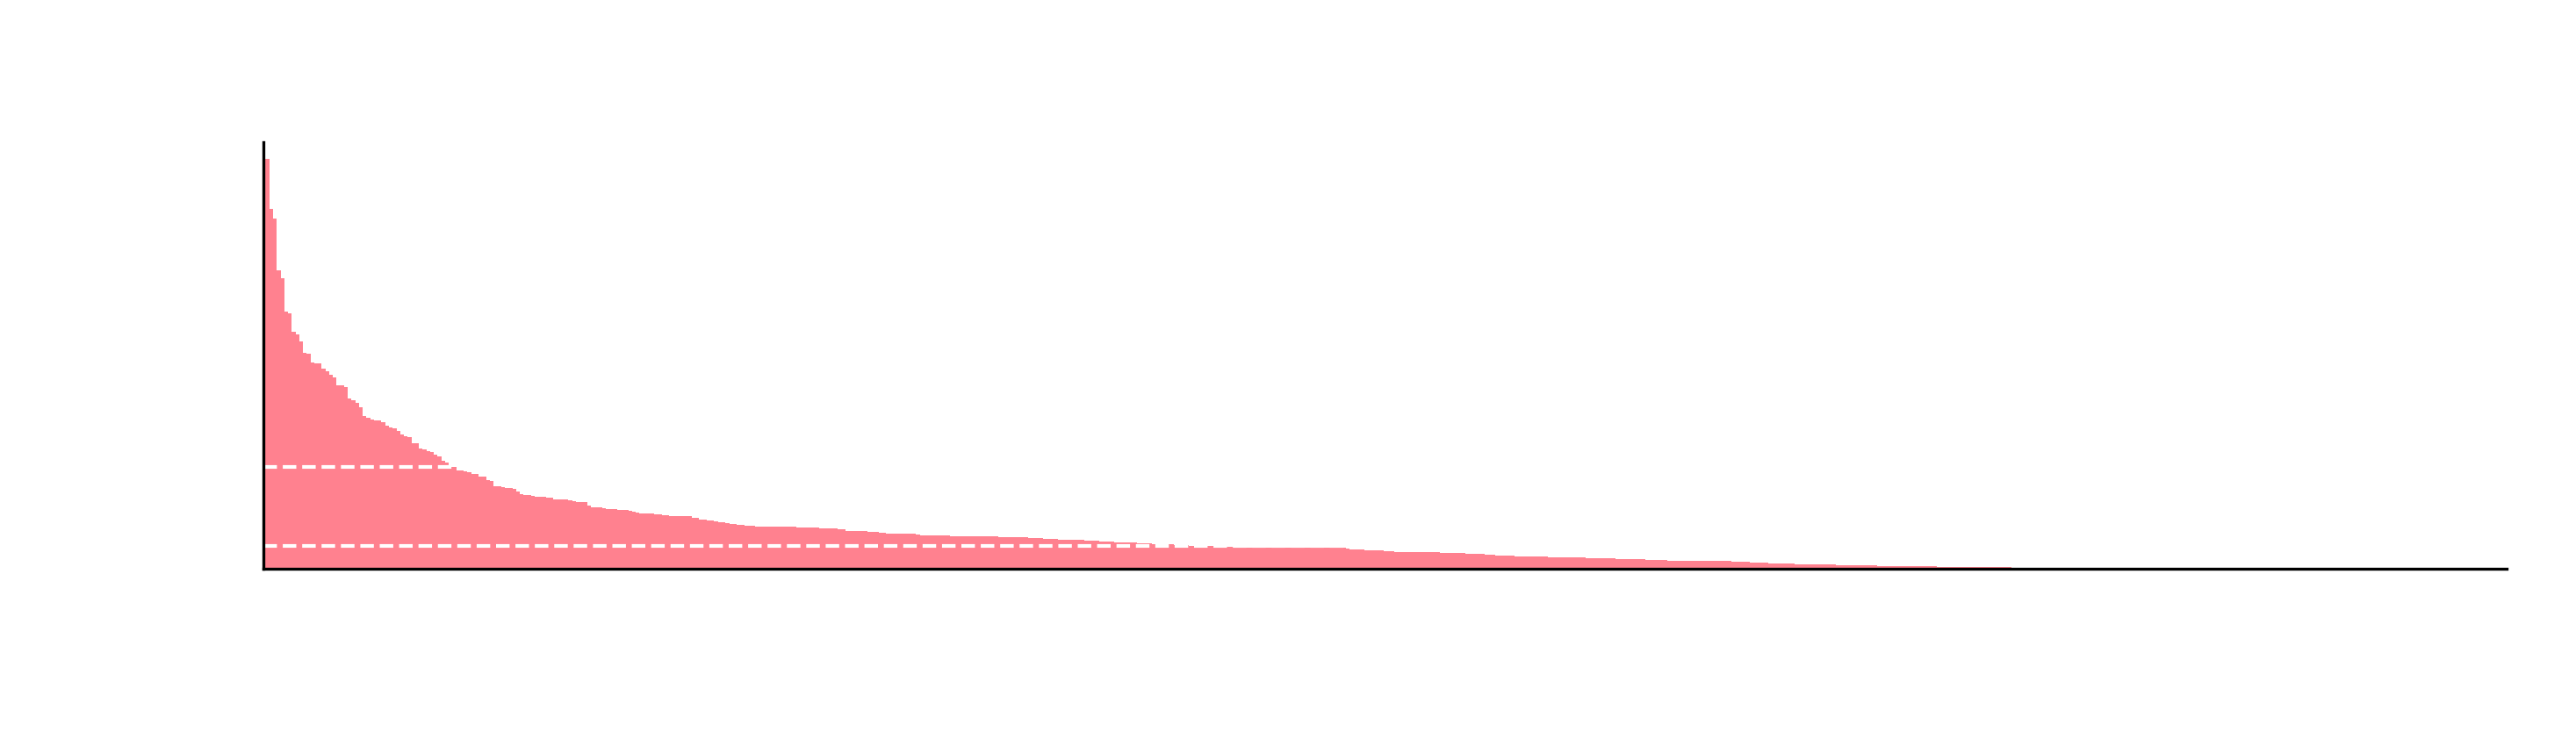

In [9]:
distros = df_funding.groupby('project_name')['tokens'].sum().sort_values(ascending=False)

f = distributions_barchart(
    distros,
    title="Cumulative Retro Funding distributions to OSS projects (Rounds 2-5)",
    ymax=1000,
    ystep=200,
    xstep=100
)

f.set_facecolor('none')

<Figure size 3740x1496 with 0 Axes>

In [10]:

client = bigquery.Client(GCP_PROJECT)

In [11]:
repo_urls = []
for glist in df['github']:
    repo_urls.extend(glist)
repo_urls = list(set(repo_urls))

In [13]:
repo_urls_str = "'" + "','".join(repo_urls) + "'"
repos_query = f"""
    select
      abp.artifact_id,
      abp.artifact_namespace,
      abp.artifact_name,
      abp.artifact_url,
      abp.artifact_type,
      rm.is_fork,
      rm.fork_count,
      rm.star_count,
      rm.language,
      rm.license_spdx_id,
      abp.project_id as oso_project_id,
    from `oso.int_artifacts_in_ossd_by_project` as abp
    join `oso.int_repo_metrics_by_project` as rm
      on abp.artifact_id = rm.artifact_id
    where abp.artifact_url in ({repo_urls_str})
"""
repos_query_result = client.query(repos_query)

repos_query_result = client.query(repos_query)
df_repos = repos_query_result.to_dataframe()
df_repos.to_parquet('data/_local/repo_metrics.parquet')

df_repos = pd.read_parquet('data/_local/repo_metrics.parquet')
df_repos.tail(1)

,artifact_id,artifact_namespace,artifact_name,artifact_url,artifact_type,is_fork,fork_count,star_count,language,license_spdx_id,oso_project_id
587,EfQGtZdYoGnJfiBDCPu_UMv8mqjIZ9FWfTcUEpUz-EY=,ethereum-optimism,asterisc,https://github.com/ethereum-optimism/asterisc,REPOSITORY,False,15,99,Go,MIT,89Tit1JWeJvJFw5pp7BjqTlEOvLXRQIw7tgZUI1_pj4=


In [23]:
oso_project_id_str = "'" + "','".join(df_repos['oso_project_id'].unique()) + "'"

In [48]:
client = clickhouse_connect.get_client(
    host=CLICKHOUSE_HOST,
    user=CLICKHOUSE_USER,
    password=CLICKHOUSE_PASS,
    secure=True
)

# results = client.query(f"""
#     select
#         project_id,
#         sample_date,
#         amount,
#         metric_name
#     from timeseries_metrics_by_project_v0 as t
#     join metrics_v0 as m on t.metric_id = m.metric_id
#     where
#         project_id in ({oso_project_id_str})
#         and metric_name in ('full_time_developers_over_30_day', 'active_developers_over_30_day')
# """)
# df_timeseries = pd.DataFrame(results.result_set, columns=results.column_names)
# df_timeseries.to_parquet('data/_local/timeseries_metrics_by_project.parquet')
df_timeseries = pd.read_parquet('data/_local/timeseries_metrics_by_project.parquet')
df_timeseries.tail(1)

,project_id,sample_date,amount,metric_name
314515,zuKa56R3a-6e4jZZUfd7UOWS66f0hkwUMt8uFboQArk=,2024-10-22,3.0,active_developers_over_30_day
